# RL-алгоритмы. Q-learning

<a href="https://colab.research.google.com/drive/1EW5MzopOO0dQTeqv6XJlKOQsMElcj0dB?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

# Импортируем зависимости

In [ ]:
import os
import sys
import numpy as np

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

%matplotlib inline

# RL-алгоритм

Цикл RL-агента в общем виде выглядит так:

![RL-агент](https://drive.google.com/uc?export=view&id=1KcDbYKxHY8tljLPQCU0AbHRtsHNO33NR)

In [ ]:
def play_and_train(env, agent, t_max=1000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []

    # Сбрасываем среду в начальное состояние — получаем первое наблюдаемое state
    s, info = env.reset()

    for t in range(t_max):
        # Агент выбирает действие на основе текущего состояния pi(a|s)
        a = agent.get_action(s)

        # Выполняем выбранное действие в среде
        # Возвращаются: следующее состояние, награда, флаги завершения и дополнительная информация
        new_s, r, done, truncated, info = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, new_s)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        # Переходим к следующему состоянию
        s = new_s
        if done:
            break

    return states, actions, rewards

# Q-learning

Q-функция

$$
Q(s,a) := (1 - \alpha) * Q(s,a) + \alpha * (r + \gamma * V(s'))
$$

где:
- $s$ - текущее состояние
- $a$ - выбранное действие
- $r$ - полученная награда
- $\gamma$ - коэффициент дисконтирования


In [ ]:
import random
from collections import defaultdict

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, get_legal_actions=None):
        self.alpha = alpha
        self.gamma = gamma
        self.get_legal_actions = get_legal_actions or (lambda s: [])
        self.Q = defaultdict(lambda: defaultdict(float))

    def get_best_action(self, state):
        """
        Возвращает действие, для которого Q-значение максимально
        """
        actions = self.get_legal_actions(state)
        if not actions:
            return None
        return max(actions, key=lambda a: self.Q[state][a])

    def get_action(self, state, epsilon=0.1):
        """
        Возвращает случайное действие с вероятностью epsilon, иначе - лучшее действие
        """
        if random.random() < epsilon:
            actions = self.get_legal_actions(state)
            return random.choice(actions) if actions else None
        else:
            return self.get_best_action(state)

    def update(self, state, action, reward, next_state):
        """
        Обновляет Q-значение:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        current_q = self.Q[state][action]

        next_actions = self.get_legal_actions(next_state)
        best_next_q = max((self.Q[next_state][a] for a in next_actions), default=0.0)

        target = reward + self.gamma * best_next_q
        self.Q[state][action] = (1 - self.alpha) * current_q + self.alpha * target

In [ ]:
agent = QLearningAgent(alpha=0.1,
                       gamma=0.99,
                       get_legal_actions=lambda s: list(range(env.action_space.n))
                      )

# Обучение агента

Here we use the Q-Learning agent on the Taxi-v3 environment from OpenAI gym.
You will need to complete a few of its functions.

In [ ]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")

n_actions = env.action_space.n

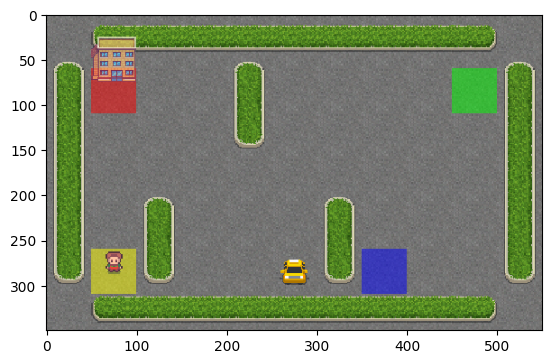

In [ ]:
s, _ = env.reset()
plt.imshow(env.render())

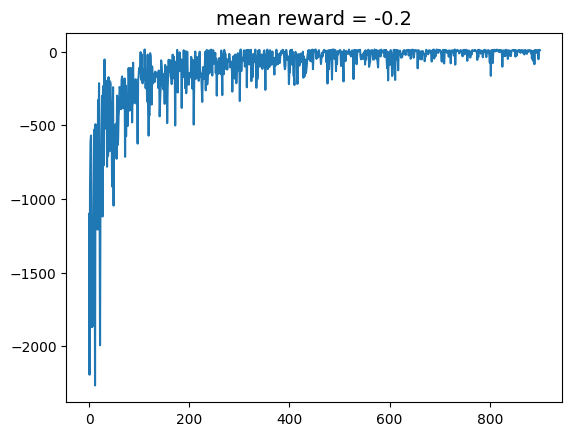

In [ ]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        plt.title("mean reward = {:.1f}".format(np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

# Тестирование обученного агента

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(env, agent, n_max_steps=200, seed=42):
    frames = []
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = agent.get_action(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(env, agent)